# CoP3E model selection and training

### Import  packages

In [1]:
#packages
from modules.train_model import TrainModel
from modules.train_model import *
from modules.feature_calculator import FeatureCalculator
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import numpy as np

### Project specific tools

In [2]:
#class
tm = TrainModel() 
fc = FeatureCalculator()

In [3]:
ensembl_pseudogene = pickle.load(open('ensembl_pseudogene.pkl', 'rb'))
datasets = pickle.load(open('datasets.pkl', 'rb'))
frqs_dict = pickle.load(open('frqs_dict.pkl', 'rb'))
selected_features = pickle.load(open('selected_features.pkl', 'rb'))

In [4]:
X = fc.get_frqs_table(frqs_dict, datasets, selected_features)
y = tm.get_targets(datasets)
X_uncertain = fc.get_uncertain_frqs_table(frqs_dict, selected_features)

### Hyperparameter tuning

In [5]:
rng = np.random.default_rng(1)
indices = rng.permutation(len(y))
X, y = X[indices], y[indices]

In [6]:
#lr = LogisticRegression(max_iter=-1)
#best_params = tm.hyperparameter_tuning(lr, X, y, tm.lr_param_grid, scoring='f1', cv=10)

In [7]:
#lr = best_params
#pickle.dump(lr, open('lr.pkl', 'wb'))
lr = pickle.load(open('lr.pkl', 'rb'))

In [8]:
lr = LogisticRegression(C=100, max_iter=5000)

In [9]:
lr_bin_preds, lr_preds = tm.train(lr, X, y, 0.4)
tm.evaluate(y, lr_bin_preds)

{'accuracy': 0.8680383114579638,
 'precision': 0.7411937377690803,
 'recall': 0.8757225433526011,
 'specificity': 0.8646366427840327,
 'f1': 0.8028616852146265}

In [10]:
#svm = SVC(max_iter=-1)
#best_params = tm.hyperparameter_tuning(svm, X, y, tm.svm_param_grid, scoring='f1', cv=10)

In [11]:
#svm = best_params
#pickle.dump(svm, open('svm.pkl', 'wb'))
svm = pickle.load(open('svm.pkl', 'rb'))

In [12]:
svm = SVC(C=100, degree=2, kernel='poly',probability=True)

In [13]:
svm_bin_preds, svm_preds = tm.train(svm, X, y, 0.4)
tm.evaluate(y, svm_bin_preds)

{'accuracy': 0.8815182688896772,
 'precision': 0.7695431472081218,
 'recall': 0.8763005780346821,
 'specificity': 0.8838280450358239,
 'f1': 0.8194594594594595}

### ensemble model

In [14]:
mlp = MLPClassifier((100, 50))

In [15]:
ensemble = tm.get_stacking(lr, svm, mlp)

In [16]:
ensemble_bin_preds, ensemble_preds = tm.train(ensemble, X, y, 0.3)
tm.evaluate(y, ensemble_bin_preds)

{'accuracy': 0.8806314295849592,
 'precision': 0.7659788626069451,
 'recall': 0.8797687861271676,
 'specificity': 0.8810133060388946,
 'f1': 0.8189400053806832}

In [17]:
pickle.dump(ensemble, open('CoP3E.pkl', 'wb'))
#CoP3E = pickle.load(open('CoP3E.pkl', 'rb'))

In [18]:
tm.optimize_thresh(y, ensemble_preds)

0.3

### precision-recall curve

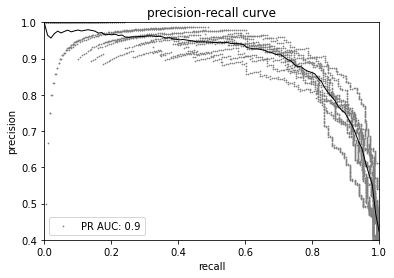

In [19]:
tm.pr_curve(y, ensemble_preds)

### accuracy versus cutoff value

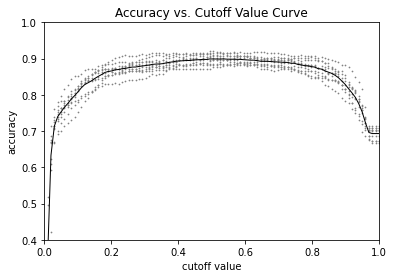

In [20]:
tm.accuracy_vs_cutoff_value(y, ensemble_preds)

### ROC curve

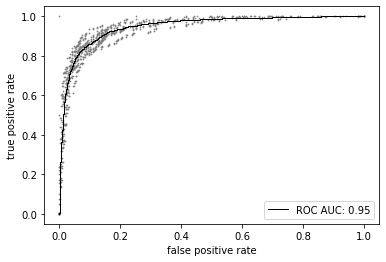

In [21]:
tm.roc_curve(y, ensemble_preds)

### two graph ROC curve

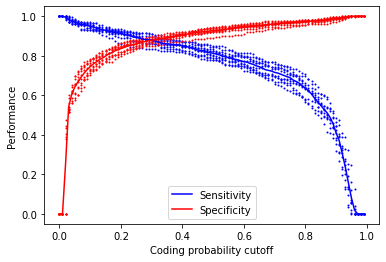

In [114]:
tm.two_graph_ROC_curve(ensemble_y_proba_CV)